## Reading-in data

First we import the required packages and modules. The last line imports the utility scoring function from the file that was published in Challenge's GitHub page. 

In [101]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import TensorSpec as ts
import pandas as pd
from scipy.special import logit
from matplotlib import pyplot as plt 
from tqdm import tqdm, trange
from time import time
from evaluate_sepsis_score import compute_prediction_utility


We set up some constants that govern how many CV folds we assume and which CV fold is used for testing, as well as number of batches for mini-batch model fitting.

In [104]:
startTime = time()
dataDir = r"E:\AALTO\Kevät2020\STATISTICAL GENETICS  & PERS. MED\Project\data"
dtype = np.double
reloadDataFlag = False
cvFoldN, cvFold = 5, 0
batchN = 10

Next we import the data from the raw data files, do some truncation for the very outlying outcomes and save the preprocessed data to a single file that is much faster to load.

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:46<00:00, 187.84it/s]


34


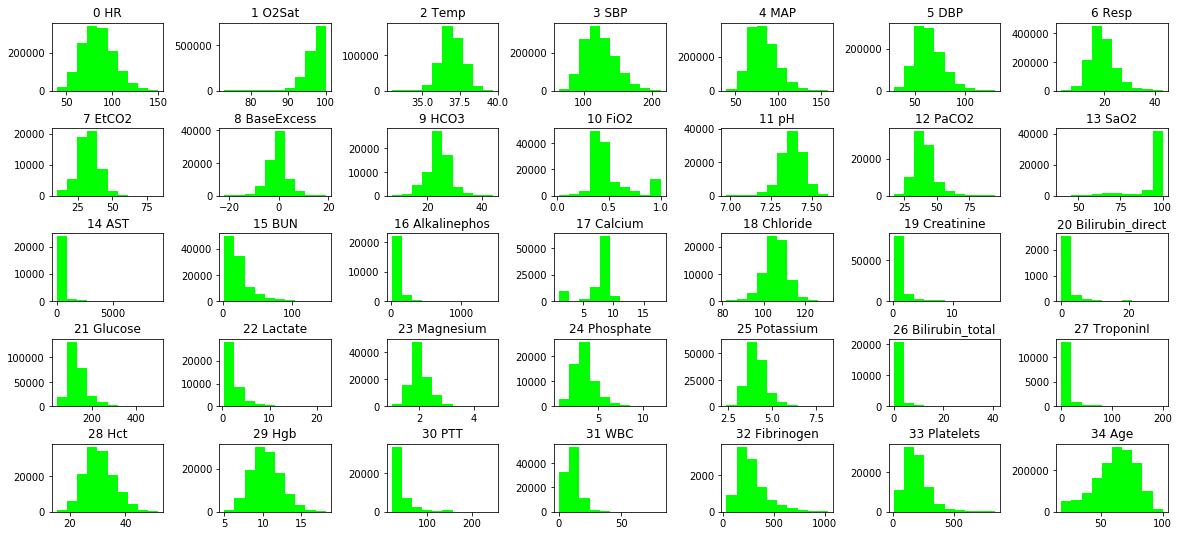

In [103]:
wspace = 0.5  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.55  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
    
if reloadDataFlag:
  subDirList = ["training_setA", "training_setB"]
  dataFrames, P = [], 0
  for subDir in subDirList:
    files = [f for f in os.listdir(os.path.join(dataDir,subDir)) if os.path.isfile(os.path.join(dataDir,subDir, f))]
    for f in tqdm(files):
      df = pd.read_csv(os.path.join(dataDir,subDir,f),sep="|")
      df["Id"] = P
      dataFrames.append(df)
      P += 1
  dataFrame = pd.concat(dataFrames)
      
  fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20,9))
  for i,ax in enumerate(axes.flatten()):
    q = np.nanquantile(dataFrame.iloc[:,i],[0,0.001,0.01,0.05,0.25,0.5,0.75,0.95,0.99,0.999,1])
    dataFrame.iloc[:,i] = np.clip(dataFrame.iloc[:,i], q[1],q[-2])
    ax.hist(dataFrame.iloc[:,i], bins=10, fc=(0, 1, 0, 1))
    ax.set_title(str(i) + " " + dataFrame.columns[i])
      
      
  plt.subplots_adjust(wspace=wspace, hspace=hspace)
  plt.show()
  
  dataFrame.to_pickle(os.path.join(dataDir,"all_raw_data.pkl"))
else:
  dataFrame = pd.read_pickle(os.path.join(dataDir,"all_raw_data.pkl"))
  P = np.unique(dataFrame["Id"]).shape[0]

We handle some discrepancies in the raw data files and fill in some missing covariates values (not outcomes).

TODO:
Here we could do our base comparison if wanted, to see how it affects the results

In [105]:
dataFrame["Unit"] = dataFrame["Unit1"] + 2*dataFrame["Unit2"] - 1 
dataFrame.loc[np.isnan(dataFrame["Unit"]),"Unit"] = 2
dataFrame["HospAdmTime"][np.isnan(dataFrame["HospAdmTime"])] = np.nanmean(dataFrame["HospAdmTime"])
dataFrameList = [df for _, df in dataFrame.groupby("Id")]

C:\Users\makke\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We reprocess the SepsisLabel column into two columns: "Deseased" - whether this patient will get sepsis at some point and "Time" time past since the patient got sepsis (is negative if patient will get sepsis in future).

In [106]:
for p in tqdm(range(P)):
  df = dataFrameList[p]
  ind = np.where(df["SepsisLabel"]==1)[0]
  if ind.size > 0:
    indMin = ind[0]
    df = df.assign(Time=np.maximum(df["ICULOS"] - df.loc[df.index[indMin],"ICULOS"],-90), Deseased=1)
  else:
    df = df.assign(Time=np.nan, Deseased=0)
  dataFrameList[p] = df
dataFrame = pd.concat(dataFrameList)

100%|███████████████████████████████████████████████████████████████████████████| 40336/40336 [00:53<00:00, 747.56it/s]


Get numpy matrices of covariates and outcomes and perform some normalization.

In [107]:
YColumns = dataFrame.columns[:34]
XColumns = ["Time", "Deseased", "Age", "Gender", "Unit", 'HospAdmTime', 'ICULOS', "Id"]
timeColumnIndex = 6
YAll = dataFrame[YColumns].values
XAll = dataFrame[XColumns].values

# Own addition
YAll_before_norm = YAll
XAll_before_norm = XAll

YScale = np.array([np.nanmean(YAll,0),np.nanstd(YAll,0)])
XScale = np.array([np.nanmean(XAll,0),np.nanstd(XAll,0)])
XScale[:,-1] = [0,1]
XScale[0,0] = 0
YAll = (YAll - YScale[0]) / YScale[1]
XAll = (XAll - XScale[0]) / XScale[1]

Split data to training and validation partitions. 

TODO:
I think it should be beneficial to check that all train,test and val had nice percentages of sespsis patientss

In [108]:
# Own code to test if better data division yields better results
all_patients = np.arange(P)
# Check which patients get sepsis at some point
target_rows = XAll_before_norm[XAll_before_norm[:,1]==1]
id_sepsis_patients = np.unique(target_rows[:,-1])

# The training/testing ratio for sepsis patients 
test_amount_sep = np.rint(0.20*id_sepsis_patients.shape[0])
sepsis_test = np.random.choice(id_sepsis_patients, test_amount_sep.astype(int),replace=False)
sepsis_train = np.setdiff1d(id_sepsis_patients, sepsis_test)

# The trainin/testing ratio for nor sepsis patients
not_sepsis_patients = np.setdiff1d(all_patients, id_sepsis_patients)
test_amount_notsep = np.rint(0.20*not_sepsis_patients.shape[0])
not_sepsis_test = np.random.choice(not_sepsis_patients, test_amount_notsep.astype(int),replace=False)
not_sepsis_train = np.setdiff1d(not_sepsis_patients, not_sepsis_test)

print("The amount of patients who get sepsis: ",id_sepsis_patients.shape[0])
print("The amount of patients who dont get sepsis: ", not_sepsis_patients.shape[0])
print("All patients: ",all_patients.shape[0])
print("_______")
print("The amount of sepsis patients choosed in test set: ",sepsis_test.shape[0])
print("The amount of sepsis patients choosed in train set",sepsis_train.shape[0])
print("The amount of healthy patients choosed in test set",not_sepsis_test.shape[0])
print("The amount of healthy patients choosed in train set", not_sepsis_train.shape[0])

idVecTest = np.concatenate((not_sepsis_test,sepsis_test))
idVecTrain = np.setdiff1d(all_patients, idVecTest)

# The initial code continues below

# Every fifth id to the testing [0]-> selects only the test indices to form list
#idVecTest = np.where((np.arange(P) % cvFoldN) == cvFold)[0]
# Everything else to training
#idVecTrain = np.setdiff1d(np.arange(P), idVecTest)

print(idVecTest)
print(idVecTrain)

# Make masks to get the training and testing sets
indTrain = np.isin(XAll[:,-1], idVecTrain)
indTest = np.isin(XAll[:,-1], idVecTest)
XTrain, YTrain = XAll[indTrain], YAll[indTrain]
XTest, YTest = XAll[indTest], YAll[indTest]

# Take the id's out
XTrain = XTrain[:,:-1]
# Fill nan's with 0
XTrain[np.isnan(XTrain)] = 0

# Mask for the y nan values 0-> nan
YoTrain = (~np.isnan(YTrain)).astype(dtype)
# Fill nan's with 0
YTrain[np.isnan(YTrain)] = 0
N,J = YTrain.shape
C = XTrain.shape[1]

The amount of patients who get sepsis:  2932
The amount of patients who dont get sepsis:  37404
All patients:  40336
_______
The amount of sepsis patients choosed in test set:  586
The amount of sepsis patients choosed in train set 2346
The amount of healthy patients choosed in test set 7481
The amount of healthy patients choosed in train set 29923
[ 7575. 24179. 17951. ...  9830.   202. 24522.]
[    1     3     4 ... 40332 40333 40335]


## Model set up and fitting

Define the model by specifying its (log) likelihood function. It is really important to understand how the fromula from the project description file matches its implementation here! Pay attention to how missing Y values are handled. Check Wiki page on Normal distribution for the likelihood if it seems unfamiliar.

This block is the primary part (and almost the only one) that you will have to change to get to models 2 and 3. Model 4 will require a wider range of adjustments.

In [109]:
# comment next line if you prefer TF eager execution mode
@tf.function(input_signature=(ts([C,J],dtype),ts([J],dtype),ts([None,C],dtype),ts([None,J],dtype),ts([None,J],dtype)))
def logLikelihood(B,sigma2, X,Y,Yo):
    # Calculate Mean vector
    Mu = tf.matmul(X, B)
    # Calculate Y-Mean vector -> Yo puts the nan- spots to zero
    R = (Y - Mu) * Yo
    # Calculate the log(sigma^2) -> Yo puts the nan- spots to zero
    logDetD_vec = tf.reduce_sum(Yo * tf.math.log(sigma2), 1)
    # Calculate the the square(Y-X)/sigma^2 
    qF_vec = tf.reduce_sum(tf.square(R) / sigma2, 1)
    # Put them all together to get the loglikelihood
    constTerm_vec = -0.5*tf.reduce_sum(Yo, 1)*np.log(2*np.pi)
    logLike_vec = -0.5*(logDetD_vec + qF_vec) + constTerm_vec
    logLike = tf.reduce_sum(logLike_vec)
    # Return value and vector? 
   
    return logLike, logLike_vec

We define the set of model parameters that will be learned and an optimizer object.

In [110]:
B = tf.Variable(tf.zeros([C,J], dtype=dtype))
sigma2_uncon = tf.Variable(tf.zeros([J], dtype=dtype))
par_list = [B, sigma2_uncon]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

We set up the optimization step.

In [111]:
# comment next line if you prefer TF eager execution mode
@tf.function(input_signature=(ts([None,C],dtype),ts([None,J],dtype),ts([None,J],dtype)))
def optimizer_step(X,Y,Yo):
  with tf.GradientTape() as tape:
    tape.watch(par_list)
    sigma2 = tf.math.softplus(sigma2_uncon)
    loss = -logLikelihood(B,sigma2, X,Y,Yo)[0] * (N/tf.shape(X)[0])
  grad_list = tape.gradient(loss, par_list)
  optimizer.apply_gradients(zip(grad_list,par_list))
  return loss

We run the optimization cycle.

In [112]:
with trange(100) as tran:
  for epoch in tran:
    ind = np.random.permutation(np.arange(YTrain.shape[0]))
    for batch in range(batchN):
      inBatchVec = ind%batchN==batch
      X,Y,Yo = XTrain[inBatchVec],YTrain[inBatchVec],YoTrain[inBatchVec]
      val = optimizer_step(X,Y,Yo)
      tran.set_postfix(batch="%.3d"%batch, loss="%015.3f"%val.numpy())

100%|███████████████████████████████████████████████| 100/100 [03:11<00:00,  1.92s/it, batch=009, loss=00011728469.461]


## Bayes classifier based on generative model

We use the fitted generative model to calculate the likelihoods of the following hypotheses: A - the current patient will never ever get sepsis and B - the current patient will get sepsis at time $t_0$. Since we do not know the time $t_0$, we consider multiple opportunities. Namely, it seems reasonable that given that the current patient has been observed for $t$ hours now, we will consider that the onset of sepsis $t_0$ could happend in any hour between $t-t_{before}$ and $t+t_{after}$.

For the sake of numerical performance efficiency the code below considers the $t_0$ being in range between hour $t_{before}$ and $T + t_{after}$, where $T$ is the total number of hours that the given patient will stay in the ICU (number of rows in patient's dataset). Obviously, this number is not availalby in advance and therefore can result in information leak from the future. In order to cope with this issue, the further sections adjust the predictions to be in line with how they are described in previous paragraph. When you work on your own implementations, please keep in mind this potential pitfall and avoid it.

In [113]:
testN = idVecTest.shape[0]
sigma2 = tf.math.softplus(sigma2_uncon)
t0SpanBefore = 12
t0SpanAfter = 48
t0Span = t0SpanBefore + t0SpanAfter
logLikelihood = logLikelihood
resArrayList = []
with tqdm(range(testN)) as progressBar:
  for indTest in progressBar:
    # The id of the targeted patient
    idTest = idVecTest[indTest]
    # Get the indexes where the boolean test is satisfied
    indIdTest = np.where(XTest[:,-1] == idTest)[0]
    # Select only the rows of targeted patient
    XTestId,YTestId = XTest[indIdTest,:-1].copy(), YTest[indIdTest].copy()
    # Get mask for nan. values in Y set
    indNan = np.isnan(YTestId)
    # Get reverse mask nan->0, useful data->1
    YoTestId = (~indNan).astype(dtype)
    # Change nan- values to 0
    YTestId[indNan] = 0
    # Reverse normalization for the time column
    tOrig = XTestId[:,timeColumnIndex] * XScale[1,timeColumnIndex] + XScale[0,timeColumnIndex]
    # The amount of rows the patient is in studied
    N = XTestId.shape[0]
    # Array full of nan's. For what purpose? 
    resArray = np.full([N,N+t0Span], np.nan)
    Y,Yo = tf.constant(YTestId), tf.constant(YoTestId)
    # Setting the X to 0 and 1 to get the probability for the current situation t0Ind
    # And do time scaling (?)
    for t0Ind in range(N+t0Span):
      X = XTestId.copy()
      if t0Ind==0:
        # X[:,1]=deceased X[:,0]=time
        X[:,1] = 0
        X[:,0] = 0
      else:
        X[:,1] = 1
        # Dont really understand this? 
        t0 = tOrig[0] - t0SpanBefore + t0Ind
        X[:,0] = ((tOrig-t0)-XScale[0,0])/XScale[1,0]
      X = tf.constant(X)
      # Loglikelihood for the sepsis labels (?) 
      logLike = logLikelihood(B,sigma2, X,Y,Yo)[1]
      # Get the probabilities to matrix as cumulative sum vector
      resArray[:,t0Ind] = np.cumsum(logLike,0)
    resArrayList.append(resArray)

100%|██████████████████████████████████████████████████████████████████████████████| 8067/8067 [07:13<00:00, 18.62it/s]


Following the scoring rules of the Challenge, we compute the utility of trivial (inaction) predictions and optimal predictions. Those are used to get a score that shall be within the range $[0,1]$.

In [114]:
dt_early   = -12
dt_optimal = -6
dt_late    = 3
best_utilities     = np.zeros(testN)
inaction_utilities = np.zeros(testN)
with tqdm(range(testN)) as progressBar:
  for indTest in progressBar:
    # Loop through the list of test patients
    idTest = idVecTest[indTest]
    # Get the indexes where the boolean test is satisfied
    indIdTest = np.where(XTest[:,-1] == idTest)[0]
    # Get the X and Y data for target patient 
    XTestId,YTestId = XTest[indIdTest,:-1].copy(), YTest[indIdTest].copy()
    # Nan values to zero and make bool mask for the sepsis
    sepLabelVec = ~np.isnan(XTestId[:,0]) * (XTestId[:,0]>=0.0)
    N = XTestId.shape[0]
    best_predictions     = np.zeros(N)
    inaction_predictions = np.zeros(N)
    action_predictions = np.ones(N)
    if np.any(sepLabelVec):
      # Optimal prediction time is the period of 6 hours after first 1 in sepsilabel  
      t_sepsis = np.argmax(sepLabelVec) - dt_optimal
      # The best prediction times for the patient
      best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, N)] = 1
    # Save the best utilities for do-something and do-nothing (?)
    best_utilities[indTest],_ = compute_prediction_utility(sepLabelVec, best_predictions)
    inaction_utilities[indTest],_ = compute_prediction_utility(sepLabelVec, inaction_predictions)
unnormalized_best_utility     = np.sum(best_utilities)
unnormalized_inaction_utility = np.sum(inaction_utilities)

  0%|                                                                                         | 0/8067 [00:00<?, ?it/s]C:\Users\makke\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
100%|█████████████████████████████████████████████████████████████████████████████| 8067/8067 [00:16<00:00, 480.25it/s]


We transform the obtained hypotheses' likelihoods into binary predictions and pass them to obtain the utilities. 

This section contains the largest space for testing and improvization since there is no clear optimal rule of how your model-based believes regarding whether and when the patient will get sepsis shall be transformed into final predictions. Current code implements a rule-based common sense version with some finetuning of couple parameters. But try to be creative and explore other opportunitiers (I guarantee that there are those that perform better).

In [115]:
priorProb = 0.1
dtAdvance = 6
bfThreshhold = -0.4
observed_utilities = np.zeros([testN])
with tqdm(range(testN)) as progressBar:
  for indTest in progressBar:
    # Loop through the list of test patients 
    idTest = idVecTest[indTest]
    # Select the patient's probabilities from the list
    resArray = resArrayList[indTest]
    # Select the covariate indexes for of current patient
    indIdTest =  np.where(XTest[:,-1] == idTest)[0]
    # The X and Y test values of the patient
    XTestId,YTestId = XTest[indIdTest,:-1].copy(), YTest[indIdTest].copy()
    # Nan values to zero and make bool mask for the sepsis
    sepLabelVec = ~np.isnan(XTestId[:,0]) * (XTestId[:,0]>=0.0)
    N = XTestId.shape[0]
    isPositive = np.any(sepLabelVec)
    A = np.tri(N, N+t0Span-1, t0Span-1) - np.tri(N, N+t0Span-1, -1)
    A[A==0] = np.nan
    A *= resArray[:,1:]-resArray[:,0,None]
    B = A.copy()
    B[:,:t0SpanBefore-1] = np.nan
    neg = np.ones([N,1])
    pos = ~np.isnan(B)
    pos = pos / np.sum(pos,1)[:,None]
    C = np.concatenate([np.zeros([N,1]),B],1)
    C[np.isnan(C)] = -np.inf
    logPrior = np.log(np.concatenate([(1-priorProb)*neg,priorProb*pos],1))
    unnormPostProb = np.exp(C + logPrior)
    normPostProb = unnormPostProb / np.sum(unnormPostProb,1)[:,None]
    postProbVec = np.sum(normPostProb[:,1:]*np.tri(N,N+t0Span-1,dtAdvance+t0SpanBefore-1),1)
    postBF = logit(postProbVec)
    observed_predictions = postBF > bfThreshhold 
    observed_utilities[indTest],_ = compute_prediction_utility(sepLabelVec, observed_predictions)

  0%|                                                                                         | 0/8067 [00:00<?, ?it/s]C:\Users\makke\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
C:\Users\makke\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
100%|█████████████████████████████████████████████████████████████████████████████| 8067/8067 [00:21<00:00, 368.10it/s]


Finally, we print the predictive score for the current CV fold.

In [117]:
unnormalized_observed_utility = np.sum(observed_utilities)
normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)
print("\nPredictive utility score %.3f, elapsed time %ds"%(normalized_observed_utility, time() - startTime))


Predictive utility score 0.023, elapsed time 889s


This example with linear model ends up in somewhat $0.03$ utility score if we average over the 5 CV folds. This is very far behind the methods from the top of the leaderboard, but still better than the best trivial predictions. However, this is why this model is marked as number 1, so the other onces shall generally perform better. Also, remember that you are not requested to beat them, but rahter conducting a course project that is aimed to give you practical skills on multivariate generative modelling that would be applicable in a wide range of biomedical applications.

Got in my tests with the initial code = 0.015 and 0.018 in two runs

By dividing the data set differently (making sure 20% of sepsis labels actually are in testing) = 0.029

# Enjoy the exciting dataset and good luck!